# Cosmos CNN Assessment

The goal of this is to make sure everyone individually understands how the code works. Thus, in filling this out only use what you remember, **documentation**, and **asking help from teaching staff**. Do not copy and paste from previous follow alongs, use LLMs, or ask other students for help.

*Follow alongs are meant to be a first exposure, but the only way to truly understand code is to implement it yourself.*

Wherever it says answer questions, make a new text cell and bold + italicize your answer

---
Import `torch` and `matplotlib.pyplot`

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# 1. Download the Chess Image Dataset from Kaggle

Use `kagglehub.dataset_download`

Hint: They provide you with the code to do this on the kaggle website

https://www.kaggle.com/datasets/niteshfre/chessman-image-dataset

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("niteshfre/chessman-image-dataset")

print("Path to dataset files:", path)

100%|██████████| 57.6M/57.6M [00:03<00:00, 16.3MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/niteshfre/chessman-image-dataset/versions/1


Use `os.listdir` and `os.path.join` to inspect the downloaded directory. Print out the directory that has the classes of the pieces.

*Answer this in text:*

What classes of pieces are there?

King Knight Pawn Queen Rook Bishop

In [3]:
import os

In [4]:
os.listdir(os.path.join(path, "Chessman-image-dataset", "Chess"))

['Bishop', 'King', 'Knight', 'Rook', 'Queen', 'Pawn']

In [5]:
path = os.path.join(path, "Chessman-image-dataset", "Chess")

# 2. Make a custom Dataset

https://docs.pytorch.org/docs/stable/data.html#torch.utils.data.Dataset

*Answer the following question by reading the docs before coding*

What 2 things need to be ovewritten from the base class?

* __getitem__
* __len__

Create a `ChessDataset` class that inherits from `torch.utils.data.Dataset`

It should take in the variables:
* `data_dir`, the path to the directory with the data in it
* `transform`, the `torchvision.transforms` that will be transform the data

In [6]:
import torch
from torch.utils.data import Dataset

In [7]:
import PIL

In [8]:
class ChessDataset(Dataset):
    def __init__(self, data_dir, transform):
        super(ChessDataset).__init__()

        self.data_dir = data_dir
        self.transform = transform

        # create a sorted list of the class labels
        # use os.listdir and os.path.isdir and sorted
        self.classes = sorted([f for f in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, f))])

        # Create a dictionary that takes in the class name as an index
        # and returns a number/int label that maps to that class

        self.classes_to_idx = {c: i for i, c in enumerate(self.classes)}

        # make a list called self.samples
        # fill the list with all your sample images
        # each sample should be a tuple (fpath, class_label)
        # where fpath is the path to the image
        # and class_label is a number/int class label

        self.samples = []
        for c in self.classes:
            for f in os.listdir(os.path.join(data_dir, c)):
                self.samples.append((os.path.join(data_dir, c, f), self.classes_to_idx[c]))

    ########################################################
    # override the first thing, return the number of samples
    ########################################################
    def __len__(self):
        return len(self.samples)
    ########################################################
    # override the second thing
    ########################################################
    # idx into the sample list,
    # use PIL.Image to open the image
    # if self.transform is set transform the image
    # return the image
    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        img = PIL.Image.open(img_path)
        if self.transform is not None:
            img = self.transform(img)
        return img, label

# 3. Create Transforms

Training Transforms
* Resize to 64 x 64
* Random side ways flip 50% of the time
* Random Rotation -45 to 45 degrees
* Random Grey Scale 10% of time
* Convert to tensor

Test Transform
* Resize to 64 x 64
* Convert to tensor

https://docs.pytorch.org/vision/0.8/transforms.html

https://docs.pytorch.org/vision/main/transforms.html

https://docs.pytorch.org/vision/main/auto_examples/transforms/plot_transforms_illustrations.html

In [21]:
from torchvision.transforms import v2

train_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=45),
    v2.RGB(),
    transforms.RandomGrayscale(p=0.1),
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    v2.RGB(),
    transforms.ToTensor(),
])

# 4. Splitting Data

Use `torch.utils.data.Subset`

https://docs.pytorch.org/docs/stable/data.html#torch.utils.data.Subset

In [22]:
import random
# get the entire dataset using your class you made in step 3
train_fullset = ChessDataset(path, transform=train_transform)
test_fullset = ChessDataset(path, transform=test_transform)
# make a list of indices of the dataset use range or np.arange
fullset_indices= list(range(len(train_fullset)))
random.shuffle(fullset_indices)
# split the indices into 80% trainset and 20% testset
# this makes two lists of indices
train_indices = fullset_indices[:int(len(fullset_indices)*0.8)]
test_indices = fullset_indices[int(len(fullset_indices)*0.8):]

# Use Subset and indices to get two new subsets
trainset = torch.utils.data.Subset(train_fullset, train_indices)
testset = torch.utils.data.Subset(test_fullset, test_indices)

# 5. Put the Datasets into Dataloaders

*   Set batch size to 16
*   Should shuffle be on or off for train and test sets? Do it
*   Turn on drop last


https://docs.pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader

In [23]:
trainloader = DataLoader(trainset, batch_size=16, shuffle=True, drop_last=True)
testloader = DataLoader(testset, batch_size=16, shuffle=False, drop_last=True)

# 6. Display an Image From Your Test Dataloader

Use `plt.imshow`, hint make sure your tensor is in the appropiate H,W,C format for `imshow` using `.permute`

torch.Size([3, 64, 64])


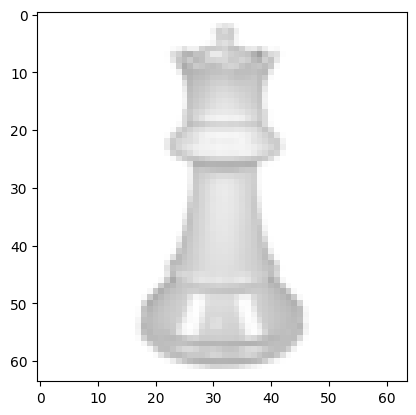

In [24]:
test_iter = iter(testloader)
images, labels = next(test_iter)

plt.imshow(images[0].permute(1, 2, 0))
print(images[0].shape)

# 7. Make a Convolutional Neural Network

* What class does your class need to inheret from?
* Do two conv layers and two max pool
    * padding = 1, kernel = 3. stride = 2
    * padding = 0, kernel = 5. stride = 1
* Use `x.view()` to flatten the conv output
* Remember this equation:

$$H_{\text{out}} = \left\lfloor \frac{H_{\text{in}} + 2P - K}{S} \right\rfloor + 1$$

$$W_{\text{out}} = \left\lfloor \frac{W_{\text{in}} + 2P - K}{S} \right\rfloor + 1$$
* 3 linear layers, use ReLU

Did you make sure your input channels and output dimensions were correct?

In [25]:
class ChessCNN(nn.Module):
    def __init__(self):
        super(ChessCNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1) # 31.5 x 31.5
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)  # 22 x 22
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1) # 10.5 x 10.5
        self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1) # 10.5 x 10.5
        self.maxpool4 = nn.MaxPool2d(kernel_size=2, stride=2)


        self.fc1 = nn.Linear(128, 256)
        self.dropout = nn.Dropout(p=0.3)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 6)

    def forward(self, x):

      x = torch.relu(self.conv1(x))
      x = self.maxpool1(x)
      x = torch.relu(self.conv2(x))
      x = self.maxpool2(x)
      x = torch.relu(self.conv3(x))
      x = self.maxpool3(x)
      x = torch.relu(self.conv4(x))
      x = self.maxpool4(x)

      x = x.view(-1, 128)
      x = torch.relu(self.fc1(x))
      x = self.dropout(x)
      x = torch.relu(self.fc2(x))
      x = self.fc3(x)

      return x

In [36]:
from torchvision.models import vgg11_bn, VGG11_BN_Weights

In [37]:
test_model = vgg11_bn(weights=VGG11_BN_Weights.IMAGENET1K_V1)

Downloading: "https://download.pytorch.org/models/vgg11_bn-6002323d.pth" to /root/.cache/torch/hub/checkpoints/vgg11_bn-6002323d.pth
100%|██████████| 507M/507M [00:05<00:00, 95.2MB/s]


In [44]:
class Net(nn.Module):
    def __init__(self, num_classes=100):
        super(Net, self).__init__()
        self.base_model = vgg11_bn(weights=VGG11_BN_Weights.IMAGENET1K_V1)

        # Freeze Featurizer
        for param in self.base_model.features.parameters():
            param.requires_grad = False

        # Replace Classifier
        self.base_model.classifier = nn.Sequential(
            nn.Linear(25088, 1280, bias=True),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1280, 6, bias=True)
        )

        for params in self.base_model.classifier.parameters():
            params.requires_grad= True

    def forward(self, x):
        outputs = self.base_model(x)
        return outputs

# 8. Training Loop

* *Answer these before coding*:
* Generally there is an outer and an inner loop, what are the two things we are iterating over and what do they mean?
Epochs and batches
* What are the 5 steps needed in the inner training loop?
    * zero gradient
    * forward
    * calculate loss
    * back prop
    * update weights


---
First:
* Create an instance of your model and put it on the device

In [45]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

In [63]:
model = Net().to(device)

---
Second:
* Initialize these variables
    * Learning rate at
$10^{-3}$
    * Loss history list
    * Number of Epochs at 10
    * optimizer, Adam

In [64]:
lr = .001
loss_history = []
num_epochs = 2
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

Second Make And Run The Training Loop

In [67]:
# Make sure your model is in the correct mode
model.train()
# outer loop
for epochs in range(num_epochs):
  print(f"Epoch {epochs}/{num_epochs}")
  total_loss = 0
    # inner loop
  for i, batch in enumerate(trainloader):
    images, labels = batch
    images = images.to(device)
    labels = labels.to(device)

    model.zero_grad()

    output = model(images)

    loss = criterion(output, labels)

    loss.backward()

    optimizer.step()

    total_loss += loss.item()


    print(f"Batch {i}/{len(trainloader)} Loss: {total_loss/(i+1)}")
  loss_history.append(total_loss/(i+1))
        # put the images and labels on the device

        # step one

        # step two

        # step three

        # step four

        # step five

        # record your history by appending loss to your list

        # print the iteration and loss

Epoch 0/2
Batch 0/27 Loss: 1.5571081638336182
Batch 1/27 Loss: 1.5518065690994263
Batch 2/27 Loss: 1.4589533011118572
Batch 3/27 Loss: 1.490167498588562
Batch 4/27 Loss: 1.4645548582077026
Batch 5/27 Loss: 1.430554489294688
Batch 6/27 Loss: 1.3784043278012956
Batch 7/27 Loss: 1.3527527004480362
Batch 8/27 Loss: 1.3003933098581102
Batch 9/27 Loss: 1.3527652680873872
Batch 10/27 Loss: 1.324485253203999
Batch 11/27 Loss: 1.3066376199324925
Batch 12/27 Loss: 1.2993187033213103
Batch 13/27 Loss: 1.401332484824317
Batch 14/27 Loss: 1.396901555856069
Batch 15/27 Loss: 1.3876974396407604
Batch 16/27 Loss: 1.4209539925350863
Batch 17/27 Loss: 1.4117824931939442
Batch 18/27 Loss: 1.3985272740062915
Batch 19/27 Loss: 1.4093083411455154
Batch 20/27 Loss: 1.3972934456098647
Batch 21/27 Loss: 1.3804388669404117
Batch 22/27 Loss: 1.3724696869435518
Batch 23/27 Loss: 1.3613111550609271
Batch 24/27 Loss: 1.3684425377845764
Batch 25/27 Loss: 1.37091480080898
Batch 26/27 Loss: 1.3612834634604278
Epoch 1/

# 9. Plot Your Loss

Make sure to add a title, x label, and y label

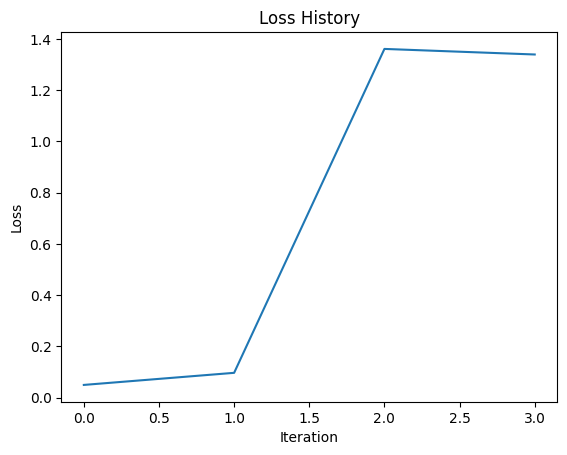

In [68]:
plt.plot(loss_history)
plt.title("Loss History")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

# 10. Calculate the accuracy of your model on the test set

Make a function that takes in a model and a testset dataloader

In [69]:
def test_model(model, dataloader):

    # make sure model is in correct mode
    model.eval()
    # create a running correct variable
    correct = 0
    # create a running loss variable
    running_loss = 0

    total =0

    # iterate through dataset and calculate accuracy
    with torch.no_grad():
      for i, batch in enumerate(dataloader):
          images, labels = batch
          images = images.to(device)
          labels = labels.to(device)

          output = model(images)

          loss = criterion(output, labels)

          running_loss += loss.item()

          predicted = torch.argmax(output, dim=1)
          correct += (predicted == labels).sum().item()
          total += labels.size(0)
    return correct / total, running_loss / len(dataloader)

            # FOR ACCURACY

            # use torch.argmax or torch.max to get the predicted labels
            # (make sure its along the right dimension by printing the shape
            # out during testing)

            # sum up correct labels, you can use == and .sum()
            # but any way works

    # return test set accuracy and running_loss / num_batches (avg loss)
    # in a tuple
    ...

Call your function

In [70]:
print(test_model(model, testloader))

(0.38392857142857145, 1.71602920123509)


# 11. Test on an internet picture

Find a random picture of a chess piece in your dataset

In [ ]:
# Download the image
from PIL import Image
import requests


url = "https://www.megachess.com/cdn/shop/products/mega-chess-buy-individual-chess-pieces-megachess-11-inch-dark-plastic-queen-giant-chess-piece-1099750399_800x.png?v=1751501129"
img = Image.open(requests.get(url, stream=True).raw).convert("RGB")
# Use PIL.Image

# Transform the image with test transform

img = test_transform(img)

# Feed into Your Model In The Correct Mode

model.eval()
pred = model(img)
dict_ = ['King', 'Queen', 'Knight', 'Rook', 'Bishop', 'Pawn']

# Turn your predicted number back into a str Prediction
pred = dict_[torch.argmax(pred, dim=1)]
# Display the image use plt.imshow
plt.imshow(img.permute(1, 2, 0))
# The title should be f"The model predicts this is a {pred}"
plt.title(f"The model predicts this is a {pred}")